# Applying Computer Vision to Fashion MNSIT

<img src="./images/fashion-mnist.png" style="width:510px"/>

Following the same approach as the **MNIST** dataset we have already seen the **Fashion-MNIST** is also very common when it comes to studying deep learing and computer vision.

Despite the fact that is looks simple the **Fashion-MNIST** can be used as a good playground for the developement of object recognition and setting together the necessary processes and pipelines to use for Computer Vision.

The original dataset can be found here: https://github.com/zalandoresearch/fashion-mnist

For the needs of this notebook the realated data can be downloaded from kaggle following this link:

https://www.kaggle.com/datasets/zalando-research/fashionmnist

note that since this is such a commonly used dataset, it is also natively supported from tensorflow and can be downloaded with the following command:

```python
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
```

In [2]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from keras.utils import to_categorical
import pickle
import tensorflow as tf


%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

### Some Utility functions

In [3]:
def plot_images_by_range(ds, index1, index2, figsize=(20, 20)):
    ncols = 4
    index2 += (index2 - index1) % ncols
    nrows = int((index2 - index1) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for row in range(nrows):
        for col in range(ncols):
            index = row * 5 + col
            d = ds.iloc[[index]]
            d = d.to_numpy()
            d = d.reshape((28, 28))
            if nrows > 1:
                axes[row, col].imshow(d)
                axes[row, col].axis('off')
            else:
                axes[col].imshow(d, cmap=plt.get_cmap('gray'))
                axes[col].axis('off')
    fig.tight_layout()
    plt.show()

def plot_images_by_index(ds, indeces, figsize=(20,10)):
    ncols = 4
    nrows = int(len(indeces) / 4)
    
    row, col = 0, 0
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for index in indeces:
        d = ds.iloc[[index]]
        d = d.to_numpy()
        d = d.reshape((28, 28))
        if nrows > 1:
            axes[row, col].imshow(d)
            axes[row, col].axis('off')
        else:
            axes[col].imshow(d, cmap=plt.get_cmap('gray'))
            axes[col].axis('off')
            
        col += 1
        if col >= ncols:
            col = 0
            row += 1
    fig.tight_layout()
    plt.show()

    
def check_model_predictions(*, model, features, expected_labels):
    y_pred=model.predict(features)
    accuracy = accuracy_score(expected_labels, y_pred)
    print('Accuracy : {0:0.4f}'. format(accuracy))
    _ = plt.pie([accuracy, 1-accuracy], labels=[f"correct: {accuracy* 100:3.1f}%", "wrong"])
    cm = confusion_matrix(expected_labels, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


# Load the fashion mnist data

In [4]:
# Load testing data.
X_train = pd.read_csv("./data/fashion-mnist_train.csv")
X_train = X_train.dropna()    
Y_train = pd.DataFrame(X_train.pop("label"))

# Load testing data.
X_test = pd.read_csv("./data/fashion-mnist_test.csv")
X_test = X_test.dropna()    
Y_test = pd.DataFrame(X_test.pop("label"))

As we can see each image is stored as a list of 784 pixel forming a $28 X28$ grid very similar to the MNIST dataset that is used for digits.

In [5]:
X_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The labels are also very similar to the **MNIST** dataset and their corresponding names are as the following:

In [6]:
ITEMS_LABELS = {
    "T_SHIRT":0,
    "TROUSER":1,
    "PULLOVER":2,
    "DRESS":3,
    "COAT":4,
    "SANDAL":5,
    "SHIRT":6,
    "SNEAKER":7,
    "BAG":8,
    "ANKLE_BOOT":9,
}


# Inspecting some randomly selected images

In [7]:
def show_same_items(label_index, figsize):
    indeces = []
    for index, row in Y_train.iterrows():
        if row["label"] == label_index:
            indeces.append(index)
        if len(indeces) >=16:
            break
    plot_images_by_index(X_train, indeces, figsize)

T_SHIRT


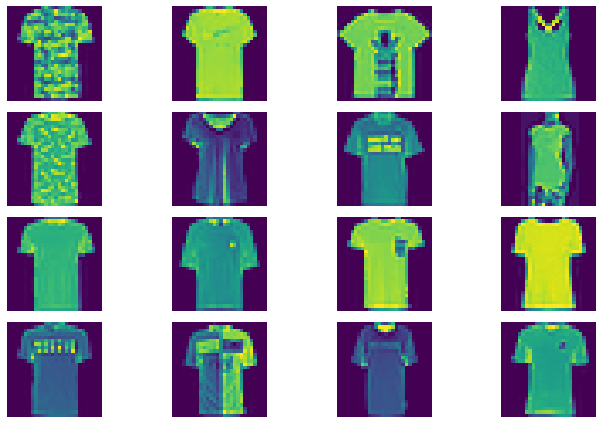

TROUSER


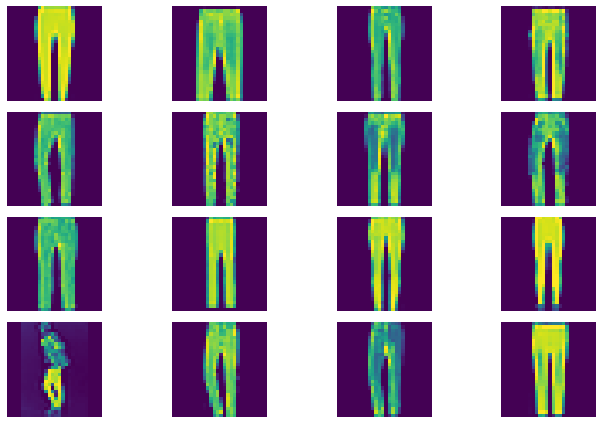

PULLOVER


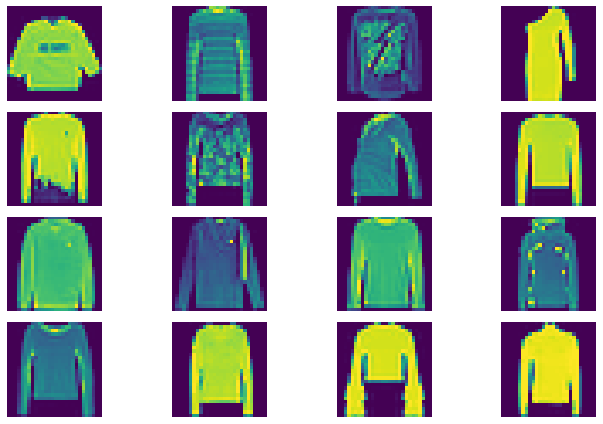

DRESS


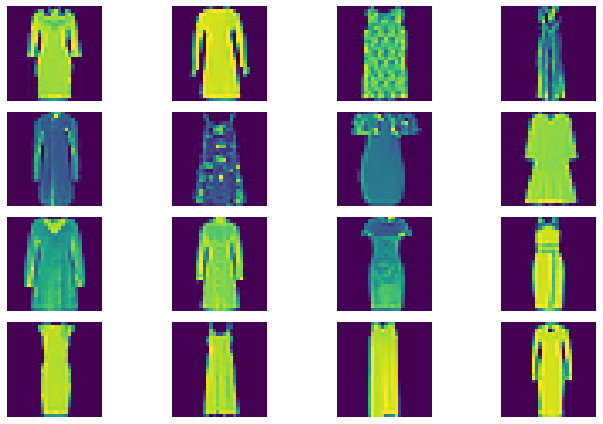

COAT


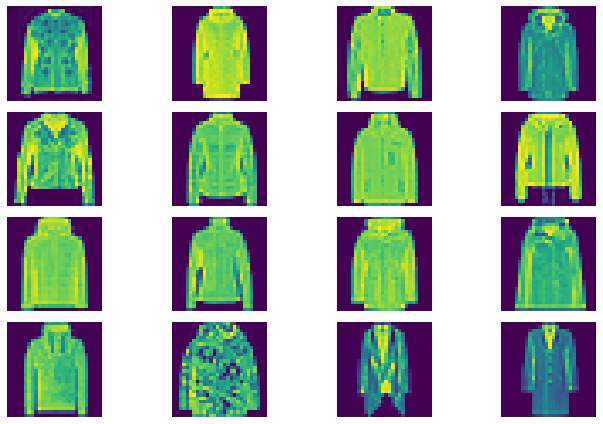

SANDAL


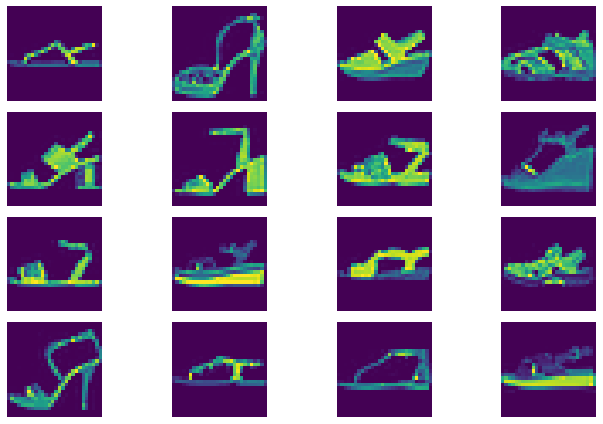

SHIRT


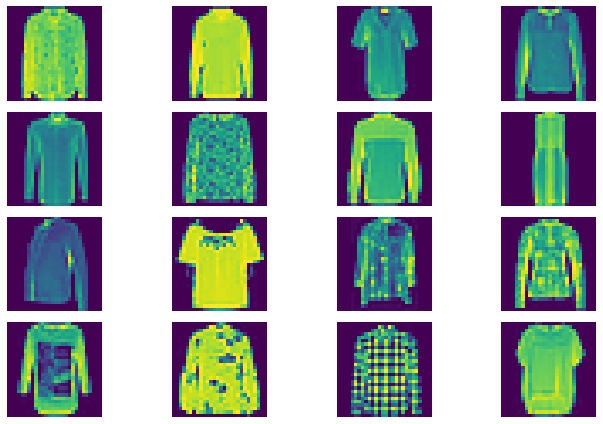

SNEAKER


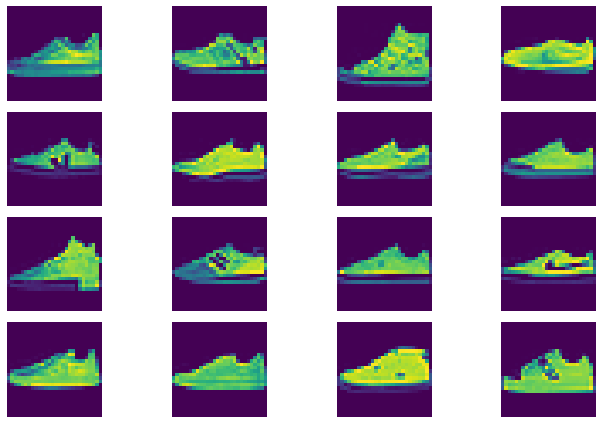

BAG


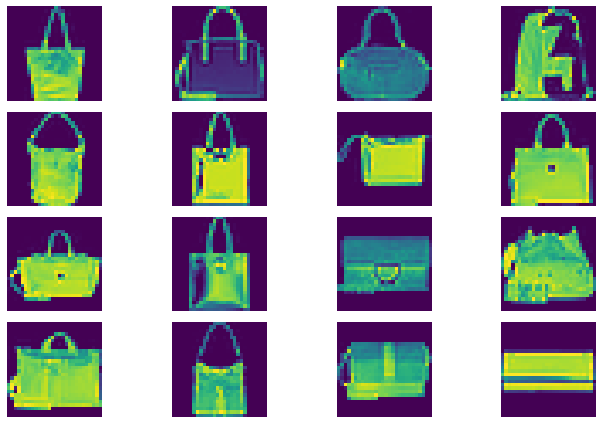

ANKLE_BOOT


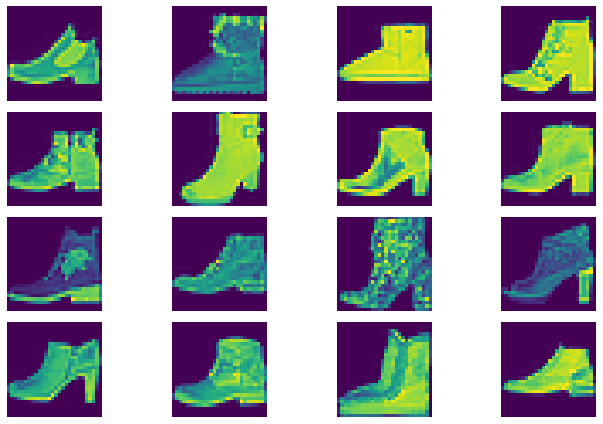

In [8]:
for name, label in ITEMS_LABELS.items():
    print(name)
    show_same_items(label, (10, 6))

In [9]:
len(X_test),len(X_train)

(10000, 60000)

# Create an image classifier using SVM

Similarly to what we have already done for the classical **MNIST** let's build a classifier using the **Support Vector Machine** algorithm:

In [10]:
normalized_X_train = X_train / 255
clf=SVC(kernel='rbf', C=5, verbose=True) 
clf.fit(normalized_X_train, Y_train)

[LibSVM].*.*
optimization finished, #iter = 2139
obj = -821.938159, rho = 0.164211
nSV = 563, nBSV = 124
...*.*
optimization finished, #iter = 4897
obj = -2633.041481, rho = -0.627474
nSV = 1328, nBSV = 434
....*..*
optimization finished, #iter = 6463
obj = -4262.874919, rho = 0.813491
nSV = 1769, nBSV = 819
.*.*
optimization finished, #iter = 2808
obj = -1227.221107, rho = -0.557177
nSV = 766, nBSV = 181
*
optimization finished, #iter = 667
obj = -159.415324, rho = 0.716022
nSV = 244, nBSV = 10
.........*...*
optimization finished, #iter = 12695
obj = -12851.983554, rho = 0.402404
nSV = 4142, nBSV = 2579
*
optimization finished, #iter = 331
obj = -63.937406, rho = -0.200923
nSV = 134, nBSV = 2
.*.*
optimization finished, #iter = 2980
obj = -1002.894733, rho = 0.308082
nSV = 843, nBSV = 118
*
optimization finished, #iter = 398
obj = -65.764996, rho = -0.533966
nSV = 162, nBSV = 3
.*
optimization finished, #iter = 1609
obj = -471.719925, rho = -0.032970
nSV = 450, nBSV = 55
..*.*
optimi

SVC(C=5, verbose=True)

### Check the accurary of the SVM classifier

Accuracy : 0.9066


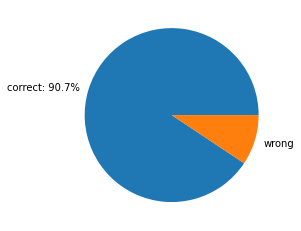

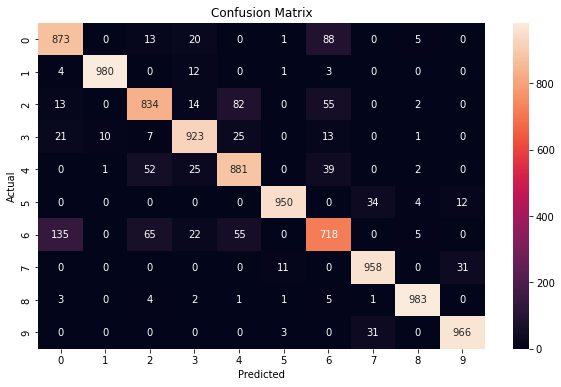

In [11]:
check_model_predictions(model=clf, features=X_test/255, expected_labels=Y_test)

# Create an Image classifier using ANN

In [12]:
model = tf.keras.Sequential( 
    [
        tf.keras.layers.Input(28*28),
        tf.keras.layers.Dense(1200, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation='softmax')
    ]                     
)

2022-10-31 15:49:43.648563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 15:49:44.049901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9383 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
model.compile(
    optimizer=tf.optimizers.Adam(), 
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [14]:
#history = nn_model.fit(X_train, Y_train, epochs=5)
x, v_x, y, v_y = train_test_split(X_train/255, Y_train, test_size=0.2)

history = model.fit(x, y, batch_size=120, epochs=120, shuffle=True ,validation_data=(v_x, v_y), verbose=1)

Epoch 1/120
 64/400 [===>..........................] - ETA: 0s - loss: 0.7964 - accuracy: 0.7240

2022-10-31 15:49:46.469442: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


400/400 [==============================] - 3s 3ms/step - loss: 0.5216 - accuracy: 0.8157 - val_loss: 0.4067 - val_accuracy: 0.8562
Epoch 2/120
400/400 [==============================] - 1s 3ms/step - loss: 0.3789 - accuracy: 0.8622 - val_loss: 0.3829 - val_accuracy: 0.8621
Epoch 3/120
400/400 [==============================] - 1s 3ms/step - loss: 0.3351 - accuracy: 0.8784 - val_loss: 0.3941 - val_accuracy: 0.8556
Epoch 4/120
400/400 [==============================] - 1s 3ms/step - loss: 0.3112 - accuracy: 0.8858 - val_loss: 0.3446 - val_accuracy: 0.8692
Epoch 5/120
400/400 [==============================] - 1s 3ms/step - loss: 0.2911 - accuracy: 0.8918 - val_loss: 0.3287 - val_accuracy: 0.8788
Epoch 6/120
400/400 [==============================] - 1s 3ms/step - loss: 0.2751 - accuracy: 0.8977 - val_loss: 0.3297 - val_accuracy: 0.8829
Epoch 7/120
400/400 [==============================] - 1s 3ms/step - loss: 0.2584 - accuracy: 0.9038 - val_loss: 0.3081 - val_accuracy: 0.8867
Epoch 8/120

400/400 [==============================] - 1s 3ms/step - loss: 0.0503 - accuracy: 0.9819 - val_loss: 0.4768 - val_accuracy: 0.8980
Epoch 59/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0550 - accuracy: 0.9803 - val_loss: 0.4954 - val_accuracy: 0.8955
Epoch 60/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0490 - accuracy: 0.9815 - val_loss: 0.5007 - val_accuracy: 0.8942
Epoch 61/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0476 - accuracy: 0.9822 - val_loss: 0.5156 - val_accuracy: 0.8969
Epoch 62/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0513 - accuracy: 0.9810 - val_loss: 0.5076 - val_accuracy: 0.8970
Epoch 63/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0441 - accuracy: 0.9839 - val_loss: 0.5179 - val_accuracy: 0.8986
Epoch 64/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0427 - accuracy: 0.9850 - val_loss: 0.5425 - val_accuracy: 0.8957
Epoch

Epoch 115/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0239 - accuracy: 0.9917 - val_loss: 0.7729 - val_accuracy: 0.8929
Epoch 116/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0242 - accuracy: 0.9915 - val_loss: 0.7453 - val_accuracy: 0.8942
Epoch 117/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.7662 - val_accuracy: 0.8963
Epoch 118/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0269 - accuracy: 0.9902 - val_loss: 0.7531 - val_accuracy: 0.8977
Epoch 119/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0262 - accuracy: 0.9905 - val_loss: 0.7648 - val_accuracy: 0.8932
Epoch 120/120
400/400 [==============================] - 1s 3ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 0.8142 - val_accuracy: 0.8929


### Check the accuracy of the model

313/313 [==============================] - 1s 2ms/step - loss: 0.7673 - accuracy: 0.8952
Accuracy:   0.8952


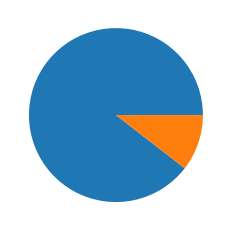

In [16]:

test_loss, test_acc = model.evaluate(X_test/255, Y_test)
print(f'Accuracy: {test_acc:8.4}')
_ = plt.pie([test_acc, 1 - test_acc])




## Checking the training progress

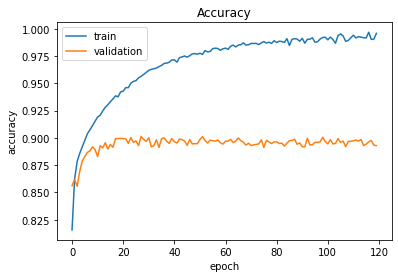

In [17]:
#Accuracy plot
plt.figure()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
_ = plt.legend()

### Overfitting 

Visually inspecting the validation accuracy (the curve that is plotted using the orange) color, we notice that after a specific data point is remains approximately the same although the accuracy of the model on the training data is improving constantly. 

The reason why the the validation accuracy does not improve is due to **overfitting**.

When training a model **overfitting** occurs when all the training data end up memorized from the weights of the model.  When this happens then the prediction accuracy in training data can go very high but the same does not apply to unseen data, in other words it does not generalize well.

